In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K

from sificc_lib import AI, utils, Event, Simulation, root_files, DataModel
np.set_printoptions(precision=2, linewidth=85, suppress=True)

%matplotlib inline

In [9]:
# model name
model_name = 'model-2b-lsrz2-FT'

# source model name to load the network weights
source_model = 'model-2b-lsrz2'

shuffle_clusters = False

# load the training data
data = DataModel('data-mtx-enough-top-6.npz', 
                 batch_size = 256, validation_percent = .05, test_percent = .1)

# append an extra dimention to the features since we are using convolutional layers
data.append_dim = True

# create an AI instance
ai = AI(data, model_name)

# randomly shuffle the training data
np.random.seed(888)
ai.data.shuffle(only_train=False)

# shuffle the clusters within each event
if shuffle_clusters:
    ai.data.shuffle_training_clusters()

In [10]:
# define the learning rate
def lr_scheduler(epoch):
    return .00003
    
# define and create the neural network architecture
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[8], 
                pos_layers=[64,32], energy_layers=[32, 16], base_l2=.0001, limbs_l2=.00003)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 54, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 6, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 6, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 384)          0           conv_2[0][0]                     
____________________________________________________________________________________________

In [11]:
#LOADING the saved trained model
ai.load(model_name)
ai.compile_model()

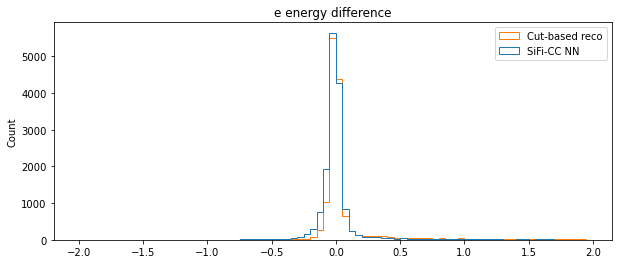

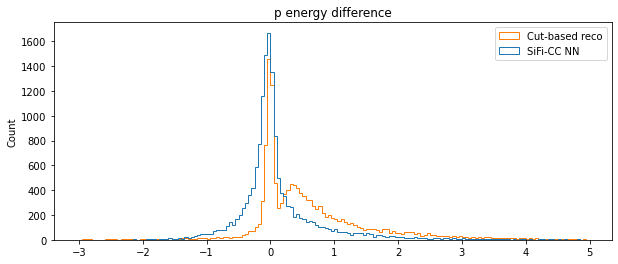

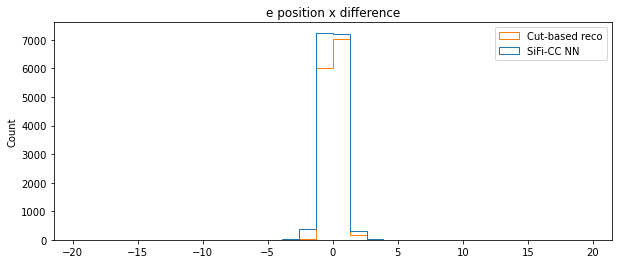

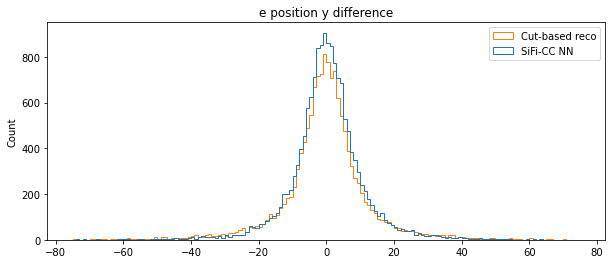

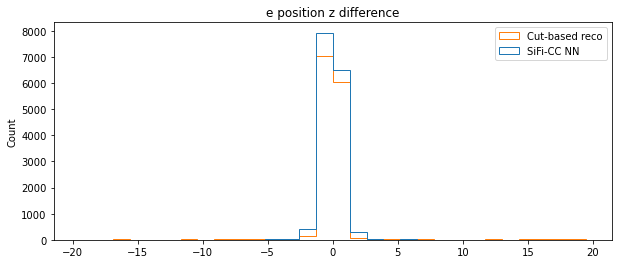

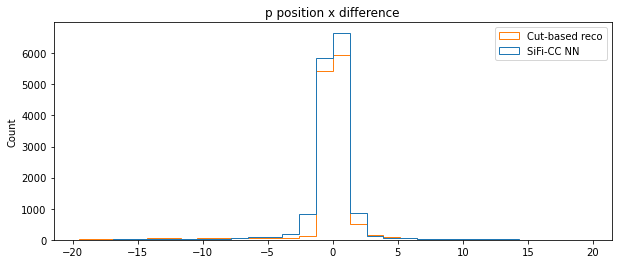

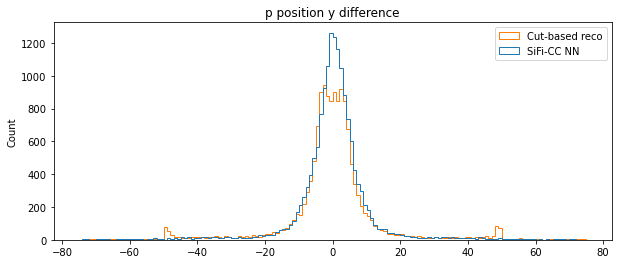

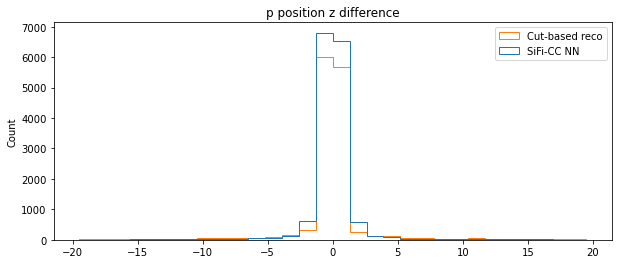

In [12]:
# plot the difference distribution between the predictions and 
# real values in comparision to the cut based reconstruction
ai.plot_diff(focus=True)

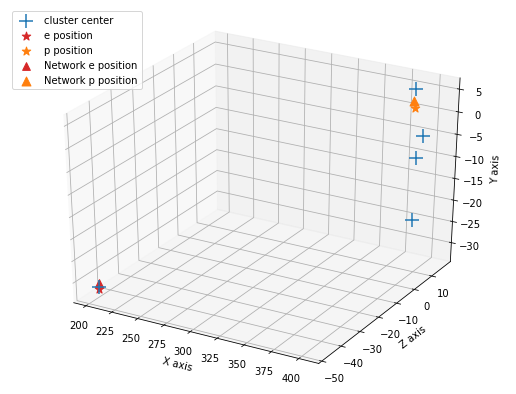

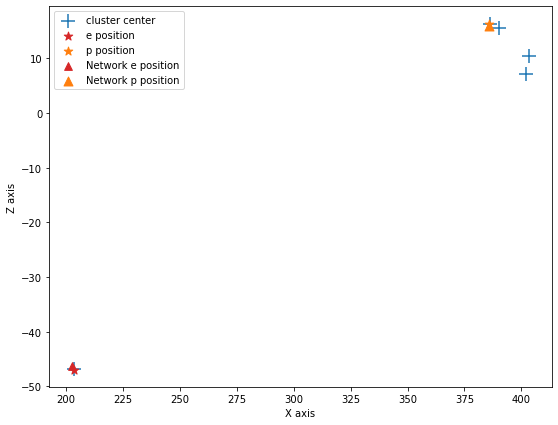

True

In [15]:
# display the sense of a single event
ai.plot_scene(535110)
ai.plot_scene(535110, is_3d=False)

In [ ]:
#TRAINING

In [5]:
# load the weights of the source model
ai.load(source_model, optimizer=False)
ai.compile_model()

In [6]:
%%time
# eliminate the components weight not intended for tuning
ai.weight_type = .05     * 0
ai.weight_e_cluster = .15* 0
ai.weight_p_cluster = .1 * 0
ai.weight_pos_x = 12     * 0
ai.weight_pos_y = 2      * 0
ai.weight_pos_z = 8      * 0
ai.weight_energy = 7     * 1

# freeze all network components
for layer in ai.model.layers:
    layer.trainable = False

# defreeze the parts to be tuned
for layer_name in ['dense_energy_1', 'dense_energy_2', 'energy']:
    layer = ai.model.get_layer(layer_name)
    layer.trainable = True

# print the trainable layers
for layer in ai.model.layers:
    if layer.trainable:
        print('{:17s}{}'.format(layer.name, layer.trainable))
print()

# compile the AI
ai.compile_model(learning_rate=.00003)
l_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler),
]

# start the training of the network
ai.train(epochs=10, shuffle=True, shuffle_clusters=shuffle_clusters, 
         verbose=0, callbacks = l_callbacks)
# evaluate on the training dataset
ai.model.evaluate(ai.data.train_x, ai.data.train_y, verbose=1)
print()

dense_energy_1   True
dense_energy_2   True
energy           True
17443/17443 [==============================] - 85s 5ms/step - loss: 2.8631 - e_cluster_loss: 0.0303 - p_cluster_loss: 0.0777 - type_loss: 0.2856 - pos_x_loss: 3.8504e-04 - pos_y_loss: 0.0370 - pos_z_loss: 4.5528e-04 - energy_loss: 0.4026 - e_cluster__cluster_accuracy: 0.9576 - p_cluster__cluster_accuracy: 0.8923 - type__type_accuracy: 0.8789 - type__type_tp_rate: 0.8252

CPU times: user 36min 21s, sys: 38.8 s, total: 37min
Wall time: 37min 1s


In [14]:
# evaluate the AI on the test set
ai.evaluate()

AI model
  Loss:        3.39696
    -Type:         0.28991 *  0.05 = 0.01450
    -Pos X:        0.00070 * 12.00 = 0.00844
    -Pos Y:        0.03808 *  2.00 = 0.07617
    -Pos Z:        0.00052 *  8.00 = 0.00413
    -Energy:       0.46219 *  7.00 = 3.23535
    -Cls e:        0.03397 *  0.15 = 0.00510
    -Cls p:        0.08168 *  0.10 = 0.00817
  Accuracy:    0.87557
    -TP rate:      0.82151
    -Cls e rate:   0.95384
    -Cls p rate:   0.88957
  Efficiency:  0.13386
  Purity:      0.12474
  Euc mean:   11.24639
  Euc std:    29.09113

Reco
  Accuracy:    0.64592
    -TP rate:      0.74924
  Efficiency:  0.10264
  Purity:      0.05959
  Euc mean:   20.44427
  Euc std:    48.46802


In [ ]:
# save the trained model
ai.save(file_name=model_name)

In [5]:
# export the predictions for image reconstruction
ai.export_predictions_root(root_name='hyb_nn_cones.root')